## HybridGibbs
One feature we get from the new sampler design is more flexibility in our Gibbs sampling.
Now we can for example run with sampler instances, which allows us to set parameters and also use all samplers in Gibbs sampling.

We call this new sampler HybridGibbs to distinguish it from classical Gibbs sampling.

### Old Gibbs sampler
First let us showcase the old Gibbs sampler:

In [1]:
import cuqi
import numpy as np
from cuqi.distribution import Gamma, Gaussian, GMRF, JointDistribution, LMRF
from cuqi.experimental.mcmc import NUTS, HybridGibbs, Conjugate, LinearRTO, ConjugateApprox, UGLA
from cuqi.testproblem import Deconvolution1D

# Forward problem
A, y_data, info = Deconvolution1D(dim=128, phantom='sinc', noise_std=0.001).get_components()

# Bayesian Inverse Problem
s = Gamma(1, 1e-4)
x = GMRF(np.zeros(A.domain_dim), 50)
y = Gaussian(A@x, lambda s: 1/s)

# Posterior
target = JointDistribution(y, x, s)(y=y_data)


C:\Users\nabr\git\CUQIpy\cuqi\problem\_problem.py:22: SyntaxWarning: invalid escape sequence '\m'
  """ Representation of a Bayesian inverse problem defined by any number of densities (distributions and likelihoods), e.g.


Warmup 50 / 50
Sample 200 / 200


 None,

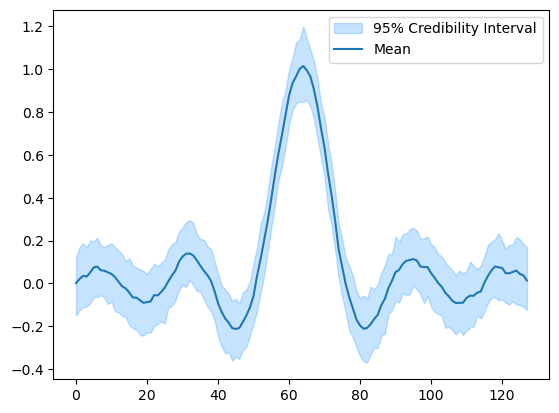

In [2]:
# Old-style Gibbs. Only supports "Static" (non-adaptive) samplers
sampling_strategy = {
    "x" : cuqi.sampler.LinearRTO,
    "s" : cuqi.sampler.Conjugate
}

sampler = cuqi.sampler.Gibbs(target, sampling_strategy)

# Sample
samples = sampler.sample(200, 50)

# Plot results
samples["x"].plot_ci()

The new HybridGibbs sampler is a generalization of the old Gibbs sampler which supported object-oriented sampler classes.

This means we can use more elaborate Gibbs sampling schemes like NUTS-within-Gibbs or similar.

First let us explore how the interface has changed by replicating the previous case:

  0% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 10% (5 of 50) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 20% (10 of 50) |####                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 30% (15 of 50) |#######                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 40% (20 of 50) |#########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (25 of 50) |############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 60% (30 of 50) |##############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 70% (35 of 50) |################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (40 of 50) |###################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (45 of 50) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  3% (6 of 200) |                       

 None,

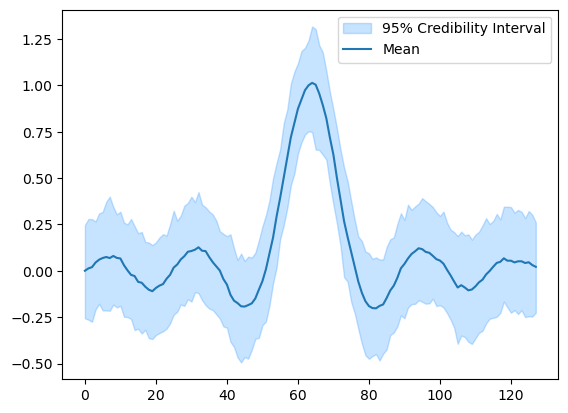

In [3]:
# New-style Hybrid Gibbs. Supports object-oriented that maintain state through iterations

sampling_strategy = {
    "x" : LinearRTO(maxit=25), # <--- Notice instance of class with set parameters
    "s" : Conjugate()          # <--- Notice instance of class with default parameters
}

sampler = HybridGibbs(target, sampling_strategy)

# Sample using new-style Gibbs
sampler.warmup(50)
sampler.sample(200)
samples = sampler.get_samples()

# Plot results
samples["x"].plot_ci()


  0% (0 of 40) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 20% (8 of 40) |#####                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (17 of 40) |##########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 65% (26 of 40) |###############         | Elapsed Time: 0:00:00 ETA:   0:00:00


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!! Using experimental samplers from mcmc module. !!!

Using experimental HybridGibbs sampler
burn-in: 20%

Automatically determined sampling strategy:
	x: LinearRTO (mcmc.experimental)
	s: Conjugate (mcmc.experimental)



 87% (35 of 40) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (40 of 40) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  5% (11 of 200) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:01
 10% (21 of 200) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 15% (31 of 200) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 20% (41 of 200) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 25% (51 of 200) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:00
 30% (61 of 200) |#######                | Elapsed Time: 0:00:00 ETA:   0:00:00
 35% (71 of 200) |########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 41% (82 of 200) |#########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 46% (92 of 200) |##########             | Elapsed Time: 0:00:00 ETA:   0:00:00
 51% (102 of 200) |###########          

Elapsed time: 1.4264881610870361


 None,

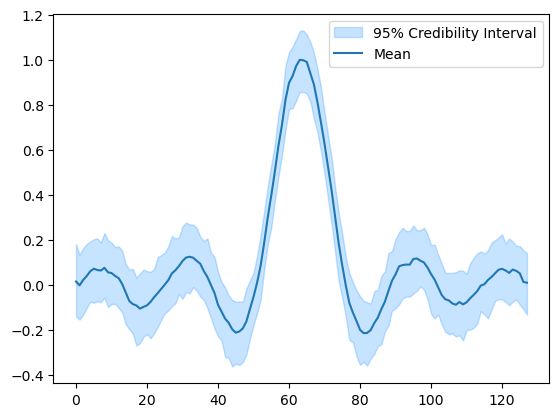

In [4]:
# Approach also works with BayesianProblem
BP = cuqi.problem.BayesianProblem(y, x, s).set_data(y=y_data)
samples = BP.sample_posterior(200, experimental=True)
samples["x"].plot_ci()

Now let us try the NUTS-within-Gibbs sampler.

In [ ]:
sampling_strategy = {
    "x" : NUTS(max_depth=10),
    "s" : Conjugate()
}

# Here we do 10 internal steps with NUTS for each Gibbs step
num_sampling_steps = {
    "x" : 10,
    "s" : 1
}

sampler = HybridGibbs(target, sampling_strategy, num_sampling_steps)

sampler.warmup(50)
sampler.sample(200)
samples = sampler.get_samples()

samples["x"].plot_ci()

The approximate conjugate case (from the webpage) also works

In [ ]:
# Try with ConjugateApprox (LMRF prior)

# Forward problem
A, y_data, info = Deconvolution1D(dim=128, phantom='square', noise_std=0.001).get_components()

# Bayesian Inverse Problem
d = Gamma(1, 1e-4)
s = Gamma(1, 1e-4)
x = LMRF(0, lambda d: 1/d, geometry=A.domain_geometry)
y = Gaussian(A@x, lambda s: 1/s)

# Posterior
target = JointDistribution(y, x, s, d)(y=y_data)

# Sampling strategy
sampling_strategy = {
    "x" : UGLA(),
    "s" : Conjugate(),
    "d" : ConjugateApprox()
}

# Gibbs sampler
sampler = HybridGibbs(target, sampling_strategy)

# Run sampler
sampler.warmup(50)
sampler.sample(200)
samples = sampler.get_samples()

# Plot
samples["x"].plot_ci()

## Ensuring conjugacy safety and flexibility
One important feature of the new Conjugate samplers is that they check the parameter relations to ensure an actual conjugate distribution is defined in the model. This was previously not checked in the older sampler module.

This will help users not accidentally using the conjugate sampler for cases that are not actually conjugate.

In [ ]:
# Forward problem
A, y_data, info = Deconvolution1D(dim=128, phantom='sinc', noise_std=0.001).get_components()

# Baysian Inverse Problem
s = Gamma(1, 1e-4)
x = GMRF(np.zeros(A.domain_dim), 50)
y = Gaussian(A@x, lambda s: s) # Accidentally using wrong conjugate relation (should have been 1/s)

# Posterior
target = JointDistribution(y, x, s)(y=y_data)

# Sampling strategy
sampling_strategy = {
    "x" : LinearRTO(maxit=25),
    "s" : Conjugate()
}

# Gibbs sampler (this should print an error)
try:
    sampler = HybridGibbs(target, sampling_strategy)
except ValueError as e:
    print("Sampler error thrown: ", e)
